In [1]:
import numpy as np
import pandas as pd
import time
import sys
import os
from joblib import Parallel, delayed
sys.path.append('../')
from packages import actv_analysis, svm, load_csv

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
############# Parameters ################
relu=5
epochs=np.array([0,90])
exps = np.arange(1,11)
min_sz_idx=0; max_sz_idx=9
selectivity =['number','size','both'][2]
num_units = 100
rate_threshold = 0.05
#########################################

for t in np.arange(8,9):
    print("test:",t)
    dir_path = os.path.dirname(os.path.realpath('../'))
    path_for_units = dir_path+'/dataframes/SVM/units/'+str(num_units)+' units sampled from distribution higher than '+str(rate_threshold)+' response rate including PN2 and PN20'
    set_folder = dir_path+'/dataframes/SVM/training_n_test/test'+str(t) # retrieve training/test sets
    save_to_folder = dir_path+'/dataframes/SVM/predictions/test'+str(t)

    for epoch in epochs:
        print("epoch:",epoch)
        for net in np.arange(1,11):
            print("net:",net)
            actv_net = actv_analysis.get_actv_net(net=net,relu=relu,epoch=epoch)
            actv = actv_net.reshape(43264,10,10,500)
            units = load_csv.units_for_svm(path=path_for_units,num_units=num_units,net=net,epoch=epoch,relu=relu)

            start_time = time.time()
            y_preds = Parallel(n_jobs=-1)(delayed(svm.SVM_fit)(set_path=set_folder, units=units, actv=actv, exp=exp) for exp in exps)

            print("--- %s seconds ---" % (time.time() - start_time))
            for exp in exps:
                pd.Series(y_preds[exp-1]).to_csv(save_to_folder+'/SVM prediction of He untrained net'+str(net)+' relu'+str(relu)+' epoch'+str(epoch)+' '+str(num_units)+' '+str(selectivity)+' units that are randomly drawn from distribution exp' + str(exp)+ '.csv', index=True)

test: 8
epoch: 0
net: 1
--- 56.35429120063782 seconds ---
--- 64.37874412536621 seconds ---
net: 2
--- 57.51541519165039 seconds ---


epoch: 0
net: 1
net: 2
net: 3
net: 4
net: 5
net: 6
net: 7
net: 8
net: 9
net: 10
epoch: 90
net: 1
net: 2
net: 3
net: 4
net: 5
net: 6
net: 7
net: 8
net: 9
net: 10


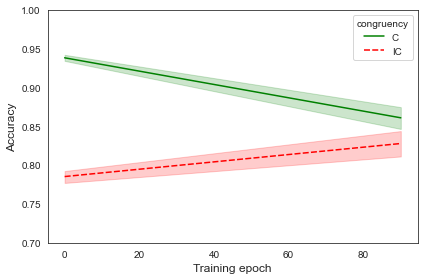

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
sys.path.append('../')

############# Parameters ################
relu=5;
nets=np.arange(1,11);
epochs=np.array([0,90])
exps = np.arange(1,11) # SVM test trials

selectivity = 'both'
num_units = 100
congruency=np.array(['C','IC'])
#########################################
test = 37
dir_path = os.path.dirname(os.path.realpath('../'))
set_path1 = dir_path+'/dataframes/SVM/training_n_test/test'+str(test)
set_path2 = dir_path+'/dataframes/SVM/predictions/test'+str(test)
save_to_folder1 = dir_path+'/dataframes/SVM/analysis'
save_to_folder2 = dir_path+'/figures'


# Make a dataframe to store SVM performance:
num_rows = len(nets)*len(epochs)*len(congruency)
df_SVM_accuracy = pd.DataFrame(index=np.arange(num_rows), columns=['epoch','net','congruency','accuracy'])
df_SVM_accuracy.loc[:,'epoch'] = np.repeat(epochs, len(nets)*len(congruency))
df_SVM_accuracy.loc[:,'net'] = np.tile(np.repeat(np.arange(1,1+len(nets)),2), len(epochs))
df_SVM_accuracy.loc[:,'congruency'] = np.tile(congruency, len(nets)*len(epochs))


# Load all test sets for SVM and get congruent and incongruent trial indices:

all_test_X = svm.get_all_test_X(set_path1,exps)
c, ic = svm.get_congruency(all_test_X, 'dot size')

i=0
for epoch in epochs:
    print("epoch:", epoch)
    for net in nets:
        print("net:", net)
        all_preds = svm.get_all_preds(set_path=set_path2, net=net, relu=relu, epoch=epoch, selectivity=selectivity, num_units=num_units, exps=exps)
        acc_C = svm.get_SVM_accuracy(c, all_test_X, all_preds)
        acc_IC = svm.get_SVM_accuracy(ic, all_test_X, all_preds)
        df_SVM_accuracy.iloc[i:i+2,3] = [acc_C, acc_IC]
        i+=2
df_SVM_accuracy.to_csv(save_to_folder1+'/SVM_accuracy_test'+str(test)+'_100units.csv', index=True)


# Plot training epoch vs SVM performance

sns.set_style("white")
ax=sns.lineplot(data=df_SVM_accuracy, x="epoch", y="accuracy", hue="congruency", palette=['g', 'r'], style='congruency', markers=False)
plt.xlabel('Training epoch',fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.7,1)
plt.tight_layout()
plt.savefig(save_to_folder2+'/training epoch vs SVM accuracy_test'+str(test)+'_100units.pdf', transparent=True)

In [156]:
read_from = dir_path+'/dataframes/SVM/analysis'
test_arr = np.array([2,3,4,5])

bb = pd.concat([pd.read_csv(save_to_folder1+'/SVM_accuracy_test'+str(i)+'_100units.csv') for i in test_arr]).drop(columns=['Unnamed: 0'])
bb.loc[:,'test'] = np.repeat(test_arr,40)

In [158]:
df_coneff = pd.DataFrame(index=np.arange(80), columns=['epoch','test','net','congruency effect'])
df_coneff.loc[:,'epoch'] = np.repeat(np.arange(0,91,90),40)
df_coneff.loc[:,'test'] = np.tile(np.repeat(test_arr,10),2)
df_coneff.loc[:,'net'] = np.tile(np.arange(1,11),8)

j=0
for epoch in np.arange(0,91,90):
    data = bb[bb['epoch']==epoch]
    for test in test_arr:
        data_ = data[data['test']==test]
        df_coneff.iloc[j:j+10,3] = data_[data_['congruency']=='C']['accuracy'].to_numpy() - data_[data_['congruency']=='IC']['accuracy'].to_numpy()
        j+=10

In [ ]:
bb[bb['congruency']=='C']['accuracy'].to_numpy() - bb[bb['congruency']=='IC']['accuracy'].to_numpy()

In [93]:
data_[data_['congruency']=='C']['accuracy'].to_numpy() - data_[data_['congruency']=='IC']['accuracy'].to_numpy()

array([ 0.04929167, -0.0035    ,  0.04204167,  0.03725   ,  0.07325   ,
        0.0515    ,  0.03179167,  0.04141667,  0.05470833,  0.066625  ])

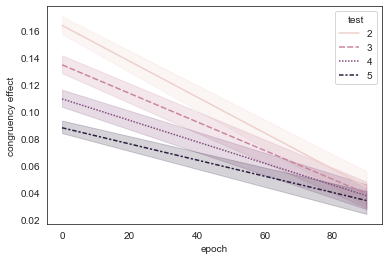

In [159]:
sns.lineplot(data = df_coneff, x='epoch', y='congruency effect', style='test', hue='test')
plt.savefig(save_to_folder2+'/training epoch vs SVM accuracy_test2345_100units.pdf', transparent=True)

In [89]:
data[data['test']==3]

,epoch,net,congruency,accuracy,test
20,90,1,C,0.847083,3
21,90,1,IC,0.814583,3
22,90,2,C,0.761250,3
23,90,2,IC,0.792292,3
24,90,3,C,0.867083,3
25,90,3,IC,0.826667,3
26,90,4,C,0.868750,3
27,90,4,IC,0.827917,3
28,90,5,C,0.845417,3
29,90,5,IC,0.756042,3


In [153]:
bb

,epoch,net,congruency,accuracy,test
0,0,1,C,0.948750,2
1,0,1,IC,0.799833,2
2,0,2,C,0.928250,2
3,0,2,IC,0.768333,2
4,0,3,C,0.936500,2
...,...,...,...,...,...
35,90,8,IC,0.823884,7
36,90,9,C,0.806429,7
37,90,9,IC,0.763259,7
38,90,10,C,0.825476,7
